# Create meta-fields

In [1]:
# Fields accessible to use in rationalization?
# ... some of which are VERY unfair and/or illegal
accessible_fields = [
    # 'sex', # >:(
    # 'race', # >:(
    # 'age',
    # 'age_cat',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
]
# Field we are trying to rationalize why it could be 1 vs 0
justifying_field = 'is_recid' # 'is_recid' or 'is_violent_recid'
# Field that is the actual data for what we are trying to determine
trueresult_field = 'two_year_recid'
# Field that is 1 if justifying==trueresult, otherwise 0.
# This is DEFINED BY ME AND NOT IN THE ORIGINAL DATA
wascorrect_field = 'pred_accurate'

# Threshold for confidence range
conf_alpha = 0.05

# Seed for 'train'/'test' split sampling
sampling_seed = 1
# Maximum number of factors to include in the whole-dataset evaluation
max_ratexpl_factors = 2

# Handle dataset

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## Import COMPAS dataset

In [3]:
# Import dataset
raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
raw_data_df.shape

(7214, 53)

In [4]:
raw_data_df[:5]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Filter dataset similar to ProPublica's method

In [5]:
# see: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
filter_data_df = raw_data_df
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
filter_data_df.shape

(6172, 53)

## Create a "prediction was correct" column

In [6]:
filter_data_df[wascorrect_field] = filter_data_df.apply(
    lambda r: 1 if r[justifying_field]==r[trueresult_field] else 0, 
    axis='columns'
)

## Split data into "training", "test"

In [7]:
split_ratio = 0.8

filter_data_df_src = filter_data_df.sample(n=int(split_ratio*len(filter_data_df)), random_state=sampling_seed)
filter_data_df_test = filter_data_df[~filter_data_df.index.isin(filter_data_df_src.index)]

print(filter_data_df_src.shape)
print(filter_data_df_test.shape)

(4937, 54)
(1235, 54)


# Define rationalization

In [8]:
from statsmodels.stats import proportion

def rationalize(target, data_df, numfields=1):
    def noIntervalOverlap(a1, a2, b1, b2):
        if a1>a2 or b1>b2:
            raise ValueError('unexpected bounds')
        if a2<b1 and a1<b1:
            return True
        if b2<a1 and b1<a1:
            return True
        return False
    breakdown = data_df[trueresult_field]
    full_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
    result_df = pd.DataFrame()
    field_groups = [[i] for i in range(len(accessible_fields))]
    for _ in range(numfields-1):
        field_groups = [[f+[i] for i in range(len(accessible_fields)) if i>f[-1]] for f in field_groups]
        field_groups = [e for l in field_groups for e in l]
    for field_ids in field_groups:
        field_names = [accessible_fields[i] for i in field_ids]
        subgroup = data_df
        for field in field_names:
            subgroup = subgroup[subgroup[field] == target[field]]
        subgroup_inv = data_df[~data_df.index.isin(subgroup.index)]
        breakdown = subgroup[trueresult_field]
        breakdown_inv = subgroup_inv[trueresult_field]
        preds = subgroup[justifying_field]
        preds_inv = subgroup_inv[justifying_field]
        corrects = subgroup[wascorrect_field]
        corrects_inv = subgroup_inv[wascorrect_field]
        if len(breakdown)>0:
            conf_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
            invg_interval = proportion.proportion_confint(sum(breakdown_inv), len(breakdown_inv), alpha=conf_alpha, method='beta')
            result_df = result_df.append({
                'field_count': len(field_names),
                'field_key': (tuple(field_names), tuple([target[fn] for fn in field_names])),
                'sample_size': len(breakdown),
                f'{trueresult_field}_mean': sum(breakdown) / len(breakdown),
                f'{justifying_field}_mean': sum(preds) / len(preds),
                f'accuracy_mean': sum(corrects) / len(corrects),
                # Confidence interval: in 95% of cases, the true underlying fraction of recidivism will fall within this interval
                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                # https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html
                f'{trueresult_field}_conf_bot': conf_interval[0],
                f'{trueresult_field}_conf_top': conf_interval[1],
                # Statistical significance
                'significant_baseline': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], full_interval[0], full_interval[1]) else 0,
                # Okay, now... all of this again for the inverse group
                # Results for the inverse group
                f'{trueresult_field}_inv_mean': sum(breakdown_inv) / len(breakdown_inv),
                f'{justifying_field}_inv_mean': sum(preds_inv) / len(preds_inv),
                f'accuracy_inv_mean': sum(corrects_inv) / len(corrects_inv),
                'significant_invgroup': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], invg_interval[0], invg_interval[1]) else 0,
            }, ignore_index=True)
    return result_df

In [9]:
breakdown = filter_data_df_src[trueresult_field]
print('true recidivism (training):', sum(breakdown)/len(breakdown))
print('true recidivism (training) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta'))

print()

breakdown = filter_data_df_test[trueresult_field]
print('true recidivism (testing):', sum(breakdown)/len(breakdown))
print('true recidivism (testing) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta'))

true recidivism (training): 0.45716021875632973
true recidivism (training) range: (0.44319184736754513, 0.4711792887904168)

true recidivism (testing): 0.44696356275303645
true recidivism (testing) range: (0.4189846057985733, 0.4751955907516002)


In [10]:
# Mini-example of selecting someone to justify both-sides of
target = filter_data_df[filter_data_df['id'] == 2680].iloc[0] # filter_data_df.sample(n=1).iloc[0]
filter_data_df[filter_data_df['id'] == target['id']]

rationalize_df = pd.DataFrame()
for numfields in [1,2,3]:
    rationalize_df = rationalize_df.append(
        rationalize(target, filter_data_df_src, numfields=numfields),
        ignore_index=True
    )

# rationalize_df.sort_values(['significant_baseline', f'{trueresult_field}_mean'])
rationalize_df[rationalize_df['significant_baseline'] == 1].sort_values(f'{trueresult_field}_mean')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,pred_accurate
1766,2680,jazze johnson,jazze,johnson,2013-05-14,Male,1986-09-29,29,25 - 45,African-American,0,8,0,0,0,-1.0,2013-05-13 07:26:35,2013-05-16 03:43:24,13006827CF10A,2013-05-13,NaN,1.0,F,Poss of Cocaine W/I/D/S 1000FT Park,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-05-14,Risk of Violence,4,Low,2013-05-14,2015-05-04,2015-08-19,0,2,720,0,0,1


,field_count,field_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup
31,3.0,"((juv_misd_count, juv_other_count, priors_coun...",1611.0,0.274984,0.291744,0.983240,0.253297,0.297495,1.0,0.545400,0.577871,0.967529,1.0
15,2.0,"((juv_other_count, priors_count), (0, 0))",1612.0,0.275434,0.292184,0.983251,0.253741,0.297948,1.0,0.545263,0.577744,0.967519,1.0
25,3.0,"((juv_fel_count, juv_other_count, priors_count...",1612.0,0.275434,0.292184,0.983251,0.253741,0.297948,1.0,0.545263,0.577744,0.967519,1.0
12,2.0,"((juv_misd_count, priors_count), (0, 0))",1667.0,0.284343,0.300540,0.983803,0.262784,0.306664,1.0,0.545260,0.578287,0.966972,1.0
22,3.0,"((juv_fel_count, juv_misd_count, priors_count)...",1667.0,0.284343,0.300540,0.983803,0.262784,0.306664,1.0,0.545260,0.578287,0.966972,1.0
3,1.0,"((priors_count,), (0,))",1668.0,0.284772,0.300959,0.983813,0.263209,0.307096,1.0,0.545121,0.578158,0.966962,1.0
8,2.0,"((juv_fel_count, priors_count), (0, 0))",1668.0,0.284772,0.300959,0.983813,0.263209,0.307096,1.0,0.545121,0.578158,0.966962,1.0
37,3.0,"((juv_other_count, priors_count, c_charge_degr...",859.0,0.302678,0.316647,0.986030,0.272094,0.334622,1.0,0.489701,0.519863,0.969838,1.0
18,2.0,"((priors_count, c_charge_degree), (0, F))",899.0,0.313682,0.327030,0.986652,0.283448,0.345143,1.0,0.489104,0.519564,0.969539,1.0
28,3.0,"((juv_fel_count, priors_count, c_charge_degree...",899.0,0.313682,0.327030,0.986652,0.283448,0.345143,1.0,0.489104,0.519564,0.969539,1.0


# Visualize small sample of rationalization bounds

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def vis(filter_data_df_src, filter_data_df_test, count_bothsides, count_factors):
    plt.rcParams['figure.figsize'] = [15, 5]
    gap_size = 10
    
    # Randomly select someone to justify negative pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 0].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n) for i in rationalize_df['field_count']],
            rationalize_df[f'{trueresult_field}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            range_lo = min(temp_df[f'{trueresult_field}_conf_top'])
            range_hi = max(temp_df[f'{trueresult_field}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )

    # Randomly select someone to justify positive pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 1].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size for i in rationalize_df['field_count']], 
            rationalize_df[f'{trueresult_field}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            if len(temp_df)==0:
                pass
            if len(temp_df[f'{trueresult_field}_conf_top'])==0:
                print(temp_df)
                raise ValueError()
            range_lo = min(temp_df[f'{trueresult_field}_conf_top'])
            if len(temp_df[f'{trueresult_field}_conf_bot'])==0:
                print(temp_df)
                raise ValueError()
            range_hi = max(temp_df[f'{trueresult_field}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )
    
    # population mean line
    breakdown = filter_data_df_src[trueresult_field]
    src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
    plt.axline((1, sum(breakdown)/len(breakdown)), slope=0, alpha=0.4)
    plt.fill_between(
        [0, 4*count_factors*count_bothsides+gap_size+2], 
        [src_range[1], src_range[1]], 
        [src_range[0], src_range[0]], 
        alpha=0.2
    )
    # 50% line
    plt.axline((1, 0.5), slope=0, alpha=0.8)
    plt.show()

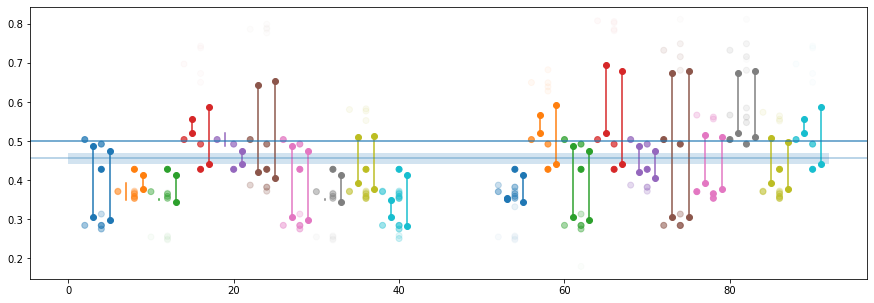

In [12]:
vis(filter_data_df_src, filter_data_df_test, 10, 2)

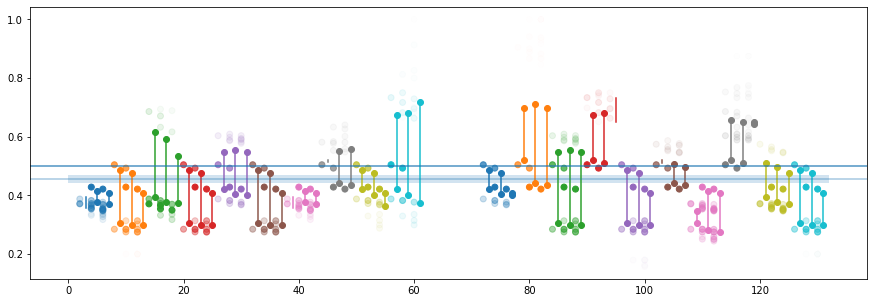

In [13]:
vis(filter_data_df_src, filter_data_df_test, 10, 3)

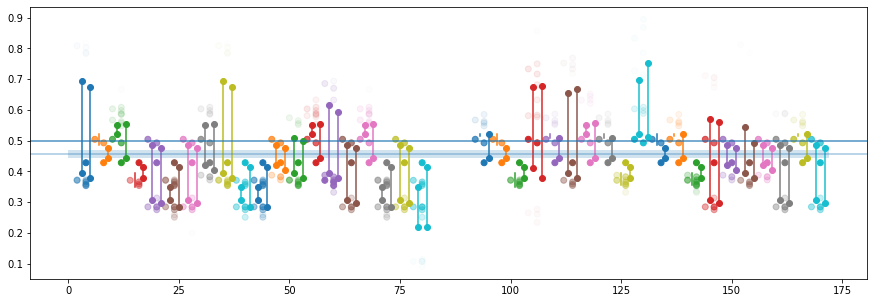

In [14]:
vis(filter_data_df_src, filter_data_df_test, 20, 2)

In [15]:
# vis(filter_data_df_src, filter_data_df_test, 20, 3)

In [16]:
# vis(filter_data_df_src, filter_data_df_test, 20, 4)

# Calculate rationalization for ALL test set samples

In [17]:
# Calculate rationalization for all test set samples
# Backup this rationalization in the file with title format f'temp-export/'

from os.path import exists
backup_path = f'temp-export/COMPAS_RAT_F{justifying_field}_T{trueresult_field}_C{conf_alpha}_NF{max_ratexpl_factors}_S{sampling_seed}.pkl'
backup_path_idmerge = f'temp-export/COMPAS_RAT_F{justifying_field}_T{trueresult_field}_C{conf_alpha}_NF{max_ratexpl_factors}_S{sampling_seed}_idmerge.pkl'

# if backup doesn't exist, make it
if (not exists(backup_path)) or (not exists(backup_path_idmerge)):
    test_rationalizations = pd.DataFrame()
    test_rationalizations_idmerge = pd.DataFrame()
    for _, case in filter_data_df_test.iterrows():
        for numfields in range(1, max_ratexpl_factors+1):
            newrats = rationalize(case, filter_data_df_src, numfields=numfields)
            test_rationalizations = pd.concat(
                [
                    test_rationalizations,
                    newrats,
                ],
                ignore_index=True,
            )
            newrats['id'] = [case['id'] for _ in range(len(newrats))]
            test_rationalizations_idmerge = pd.concat(
                [
                    test_rationalizations_idmerge,
                    newrats,
                ],
                ignore_index=True,
            )
    # Add column representing the 'side' that each rationalization is in favor of
    breakdown = filter_data_df_src[trueresult_field]
    justifying_ref_avg = sum(breakdown)/len(breakdown)
    test_rationalizations[f'{justifying_field}_rat_side'] = test_rationalizations.apply(lambda r: 1 if r[f'{trueresult_field}_mean']>justifying_ref_avg else 0, axis=1)
    test_rationalizations_idmerge[f'{justifying_field}_rat_side'] = test_rationalizations_idmerge.apply(lambda r: 1 if r[f'{trueresult_field}_mean']>justifying_ref_avg else 0, axis=1)
    test_rationalizations = test_rationalizations.drop_duplicates()
    # Save backups
    test_rationalizations.to_pickle(backup_path)
    test_rationalizations_idmerge.to_pickle(backup_path_idmerge)
# load backups
test_rationalizations = pd.read_pickle(backup_path)
test_rationalizations_idmerge = pd.read_pickle(backup_path_idmerge)

In [18]:
test_rationalizations[:2]
test_rationalizations_idmerge[:2]

,field_count,field_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,is_recid_rat_side
0,1.0,"((juv_fel_count,), (0,))",4760.0,0.447059,0.473319,0.973739,0.432866,0.461317,0.0,0.728814,0.785311,0.943503,1.0,0
1,1.0,"((juv_misd_count,), (0,))",4664.0,0.442110,0.468696,0.973413,0.427790,0.456503,0.0,0.714286,0.754579,0.959707,1.0,0


,field_count,field_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,id,is_recid_rat_side
0,1.0,"((juv_fel_count,), (0,))",4760.0,0.447059,0.473319,0.973739,0.432866,0.461317,0.0,0.728814,0.785311,0.943503,1.0,4,0
1,1.0,"((juv_misd_count,), (0,))",4664.0,0.442110,0.468696,0.973413,0.427790,0.456503,0.0,0.714286,0.754579,0.959707,1.0,4,0


In [19]:
# Calculate confidence interval of entire training dataset
breakdown = filter_data_df_src[trueresult_field]
src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
src_range

(0.44319184736754513, 0.4711792887904168)

# Do solo multi-element rationalizing

## Show distribution of confidence interval gaps

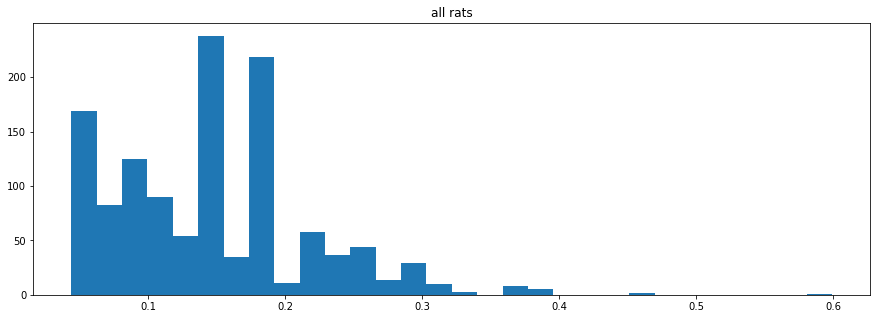

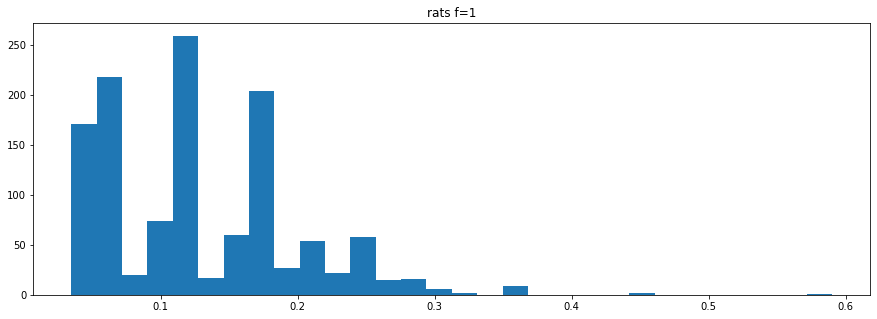

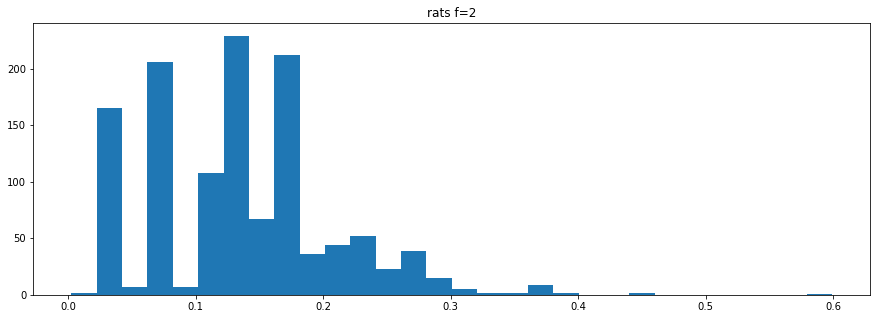

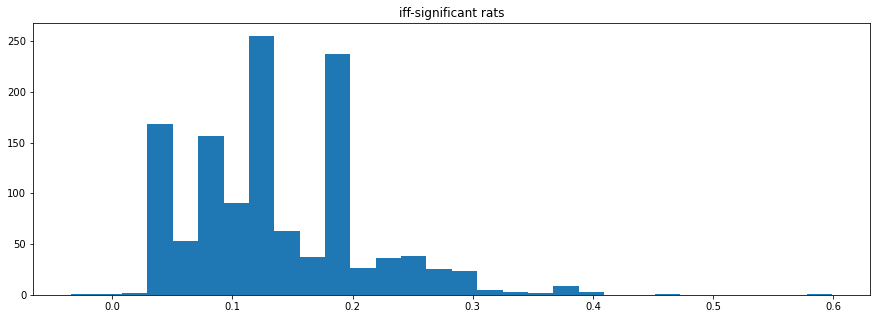

In [20]:
import matplotlib.pyplot as plt
import numpy as np

num_bins = 30

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0"
# (negative value means no gap, they overlap)
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge.groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('all rats')
plt.show()

# CI gaps ... for size-1 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['field_count']==1].groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=1')
plt.show()

# CI gaps ... for size-2 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['field_count']==2].groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=2')
plt.show()

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0" for ONLY the significant sets
test_signif_rat = test_rationalizations_idmerge[test_rationalizations_idmerge['significant_baseline']==1]
temp_gaps = []
for x_id, x_rat in test_signif_rat.groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats')
plt.show() 

## Show frequency of single-rat and double-rat cases

In [21]:
tags = {'id':[], 'rat_goal':[], 'ratted_single':[], 'ratted_double':[]}
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['significant_baseline'] == 1].groupby(['id']):
    tags['id'].append(x_id)
    x_goal = filter_data_df_test[filter_data_df_test['id']==x_id].iloc[0][justifying_field]
    tags['rat_goal'].append(x_goal)
    # figure out if goal has been achieved to prediction case-by-case
    tags['ratted_single'].append(any(x_rat[f'{justifying_field}_rat_side']==x_goal))
    # figure out if goal could be achievable either way case-by-case
    rat_total = sum(x_rat[f'{justifying_field}_rat_side'])
    tags['ratted_double'].append(rat_total<len(x_rat[f'{justifying_field}_rat_side']) and rat_total>0)
test_ratsides = pd.DataFrame(tags)
test_ratsides[:5]

,id,rat_goal,ratted_single,ratted_double
0,4,1,True,False
1,22,0,True,True
2,23,1,True,True
3,26,1,True,True
4,28,0,True,True


In [22]:
print('successful rat single', sum(test_ratsides['ratted_single'])/len(test_ratsides))
print('successful rat double', sum(test_ratsides['ratted_double'])/len(test_ratsides))

successful rat single 0.9149797570850202
successful rat double 0.6850202429149798


In [23]:
# for all cases, show distribution of 2-rat (could support both), exclusive-pro-rat (only for preds), and exclusive-non-rat (against preds)
temp_counts = {}
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['significant_baseline'] == 1].groupby(['id']):
    x_ratted = test_ratsides[test_ratsides['id']==x_id].iloc[0]
    if x_ratted['rat_goal'] not in temp_counts:
        # Initialize empty entry
        temp_counts[x_ratted['rat_goal']] = {
            '2rat': 0,
            'xprorat': 0,
            'xnonrat': 0,
        }
    if x_ratted['ratted_double']:
        temp_counts[x_ratted['rat_goal']]['2rat'] += 1
    elif x_ratted['ratted_single']:
        temp_counts[x_ratted['rat_goal']]['xprorat'] += 1
    else:
        temp_counts[x_ratted['rat_goal']]['xnonrat'] += 1

temp_counts

{1: {'2rat': 427, 'xprorat': 76, 'xnonrat': 95},
 0: {'2rat': 419, 'xprorat': 208, 'xnonrat': 10}}

# Do group multi-element rationalizing

In [24]:
# Determine if a field key (set of fields and values) applies to a given dataset row
def key_applicable(row, field_key):
    for i in range(len(field_key[0])):
        fname = field_key[0][i]
        fval = field_key[1][i]
        if row[fname]!=fval:
            return False
    return True
    
# Pick out examples from a given dataset that could apply to each field-key (in a iter-able structure)
def identify_examples(data_df, fieldkeys, fieldkeys_goals):
    fieldkey_relevantsrc = pd.DataFrame()
    for k, kgoal in zip(fieldkeys, fieldkeys_goals):
        subset = data_df[
            data_df.apply(lambda r: key_applicable(r,k), axis='columns')
        ][['id', justifying_field, trueresult_field]]
        subset['field_key'] = [k for _ in range(len(subset))]
        subset[f'{justifying_field}_app'] = [(1 if e==kgoal else 0) for e in subset[justifying_field]]
        if len(subset)>0:
            fieldkey_relevantsrc = fieldkey_relevantsrc.append(subset)
    fieldkey_relevantsrc_gb = fieldkey_relevantsrc.groupby(by=['field_key'])
    return fieldkey_relevantsrc_gb

## Simple mass group rationalizing, using test set??

### Note that this code is NOT handling things as cleanly as ideal...

Each case has multiple rats that it can be labeled with

Each rat has multiple cases that it applies to

There is a whole set of cases, and a whole set of rats

We need to pick a subset of rats for everything that minimizes conflict (cases with active rats on both sides) and maximizes coverage (rats can justify maximum number of cases?)

In [25]:
# Produce a df with each test set entry paired up with justification used for it...

# Initialize all datapoints to justify
temp_cases = pd.DataFrame(filter_data_df_test)
# Initialize all reasons that are usable
temp_rats = pd.DataFrame(test_rationalizations)
temp_rats = temp_rats[temp_rats['significant_baseline']==1]
# Initialize all reasons that we end up applying
temp_rat_conclusions = pd.DataFrame({'id':[], 'rat_field_key':[], 'rat_works':[]})

In [26]:
# Amass all possible justifications applicable to the cases
temp_rats_relevantsrc_gb = identify_examples(
    temp_cases, 
    temp_rats['field_key'], 
    temp_rats[f'{justifying_field}_rat_side']
)

# Summarize breakdown of justification applicability
temp_rat_stats = pd.DataFrame()
# temp_rat_stats[f'{justifying_field}_mean'] = temp_rats_relevantsrc_gb.apply(
#     lambda x: x[justifying_field].mean()
# )
# temp_rat_stats[f'{trueresult_field}_mean'] = temp_rats_relevantsrc_gb.apply(
#     lambda x: x[trueresult_field].mean()
# )
temp_rat_stats[f'{justifying_field}_app_mean'] = temp_rats_relevantsrc_gb.apply(
    lambda x: x[f'{justifying_field}_app'].mean()
)
temp_rat_stats['samples'] = temp_rats_relevantsrc_gb.apply(
    lambda x: len(x)
)
temp_rat_stats[f'{justifying_field}_app_ids'] = temp_rats_relevantsrc_gb.apply(
    lambda x: list(zip(x['id'], x[f'{justifying_field}_app']))
)
temp_rat_stats = temp_rat_stats.reset_index(level=0, col_fill='field_key')
temp_rat_stats = temp_rat_stats.merge(
    temp_rats[['field_key', f'{justifying_field}_rat_side']], left_on='field_key', right_on='field_key'
)

In [27]:
temp_rat_stats.sort_values([f'{justifying_field}_app_mean', f'samples'], ascending=[False, False])[:5]

,field_key,is_recid_app_mean,samples,is_recid_app_ids,is_recid_rat_side
236,"((priors_count, c_charge_desc), (0, DUI Level ...",1.0,8,"[(68, 1), (222, 1), (1176, 1), (3207, 1), (789...",0
157,"((juv_other_count, c_charge_desc), (1, Possess...",1.0,6,"[(4, 1), (6365, 1), (6968, 1), (7772, 1), (862...",1
228,"((priors_count, c_charge_degree), (17, F))",1.0,6,"[(1595, 1), (3362, 1), (6882, 1), (6886, 1), (...",1
254,"((priors_count, c_charge_desc), (10, arrest ca...",1.0,6,"[(2845, 1), (5116, 1), (5119, 1), (7919, 1), (...",1
10,"((c_charge_degree, c_charge_desc), (M, DUI - E...",1.0,5,"[(6066, 1), (6131, 1), (7725, 1), (7847, 1), (...",0


In [28]:
# Apply best explanation(s)...
used_cases = []
used_rats = []
temp_rat_perfects = temp_rat_stats[temp_rat_stats[f'{justifying_field}_app_mean']==1]
if len(temp_rat_perfects)>0:
    # if there is nonzero number of perfect expls, take all perfect expls and apply them
    print(f'adding perfect expls: {len(temp_rat_perfects)} of them')
    temp_rat_applying = temp_rat_perfects.sort_values([f'samples'], ascending=[False])
    for _,r in temp_rat_applying.iterrows():
        app_ids = r[f'{justifying_field}_app_ids']
        app_ids = [(i,works) for (i,works) in app_ids if not any(temp_rat_conclusions['id']==i)]
        temp_rat_conclusions = temp_rat_conclusions.append(pd.DataFrame({
            'id': [i for (i,_) in app_ids], 
            'rat_field_key': [r['field_key'] for _ in range(len(app_ids))],
            'rat_works': [works for (_,works) in app_ids],
        }))
        used_cases = used_cases+[i for (i,_) in app_ids]
        used_rats = used_rats+[rat for rat in temp_rat_perfects['field_key']]
elif len(temp_rat_stats)>0:
    # Otherwise, take the top effective one and apply it
    print(f'adding top non-perfect expl')
    temp_rat_applying = temp_rat_stats.sort_values([f'{justifying_field}_app_mean', f'samples'], ascending=[False, False])
    r = temp_rat_applying.iloc[0]
    app_ids = r[f'{justifying_field}_app_ids']
    app_ids = [(i,works) for (i,works) in app_ids if (i not in temp_rat_conclusions['id'])]
    temp_rat_conclusions = temp_rat_conclusions.append(pd.DataFrame({
        'id': [i for (i,_) in app_ids], 
        'rat_field_key': [r['field_key'] for _ in range(len(app_ids))],
        'rat_works': [works for (_,works) in app_ids],
    }))
    used_cases = [i for (i,_) in app_ids]
    used_rats = [rat for rat in temp_rat_perfects['field_key']]
print(f'now have {len(temp_rat_conclusions)} cases handled')

adding perfect expls: 52 of them
now have 70 cases handled


In [29]:
# Remove cases that have been explained, rationales that have been used
temp_cases = temp_cases[[
    (not (i in used_cases)) 
    for i in temp_cases['id']
]]

print(f'remaining {len(temp_cases)} cases, {len(temp_rats)} rationales')

remaining 1165 cases, 259 rationales


In [30]:
# TODO do "trained" mass group rationalizing using the entire training set, maximizing what within the training set we can justify and applying it to the test set as a whole

In [31]:
# TODO do one-by-one rationalizing by going through the test set in order, selecting a justification for each and minimizing future conflict (greedy approach)

In [32]:
# Pick out every distinct set of field-value examinations that could be used for justification
fields_keys_gb = test_rationalizations_idmerge[test_rationalizations_idmerge['significant_baseline']==1].merge(
    filter_data_df_test[['id', justifying_field, trueresult_field]], left_on='id', right_on='id'
).groupby(
    by=['field_key']
)

In [33]:
fields_keys_relevantsrc_gb = identify_examples(filter_data_df_src, fields_keys_gb.groups.keys())

TypeError: identify_examples() missing 1 required positional argument: 'fieldkeys_goals'

In [ ]:
fields_keys = pd.DataFrame()
fields_keys[f'{justifying_field}_rat_side'] = fields_keys_gb.apply(
    lambda x: x[f'{justifying_field}_rat_side'].mean()
)
# Add train set stats
fields_keys[f'src_{justifying_field}_mean'] = fields_keys_relevantsrc_gb.apply(
    lambda x: x[justifying_field].mean()
)
fields_keys[f'src_{trueresult_field}_mean'] = fields_keys_relevantsrc_gb.apply(
    lambda x: x[trueresult_field].mean()
)
fields_keys['src_samples'] = fields_keys_relevantsrc_gb.apply(
    lambda x: len(x)
)
fields_keys['src_id_samples'] = fields_keys_relevantsrc_gb.apply(
    lambda x: list(x['id'])
)
# Add test set stats
fields_keys[f'test_{justifying_field}_mean'] = fields_keys_gb.apply(
    lambda x: x[justifying_field].mean()
)
fields_keys[f'test_{trueresult_field}_mean'] = fields_keys_gb.apply(
    lambda x: x[trueresult_field].mean()
)
fields_keys['test_samples'] = fields_keys_gb.apply(
    lambda x: len(x)
)
fields_keys['test_id_samples'] = fields_keys_gb.apply(
    lambda x: list(x['id'])
)
fields_keys = fields_keys.reset_index(level=0)
fields_keys[:5]#.sort_values('test_samples').sort_values(f'test_{justifying_field}_mean')

In [ ]:
test_rationalizations_idmerge[:5]

temp_singlemerge = test_rationalizations_idmerge.merge(filter_data_df_test[['id', justifying_field]], left_on='id', right_on='id')
temp_singlemerge[:5]